<a href="https://colab.research.google.com/github/crazoter/colab_ipynbs/blob/main/Auto_Jigidi_verifier_for_Ozoxmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How Google colab works
See https://www.youtube.com/watch?v=inN8seMm7UI

This document serves as a prototype (based in Linux bash & Python) on how you can incorporate this implementation on your server. It shows you how you can set up the environment on a Linux server and shows the output for each code block.

You can use it by porting it to your server. Alternatively, you can also perform the checks using this script if you are somehow able to export all the necessary files required. Google boots up a Linux virtual machine (that automatically shuts down after 12h / with inactivity) that is linked to your account, on which you can run these scripts.

The code compiled into 1 code block can be found at the very bottom of this document. 

To use, you can save a copy in your Google Drive.

# Goal
Automate verification process

# Concept

1. Use Selenium to start a chrome browser process on the Linux server. 
  Program will then navigate to the puzzle URL and screenshot the puzzle image for verification uses. 
  1. Program will also modify the page and take screenshots to mimic usernames and completion times, so that the images will be as close as possible to what is shown on the jigidi website. It will also check leaderboard winners against the current leaderboard on the website.
2. Perform scale-invariant template matching using OpenCV for the puzzle image, username and completion time. starting from 20% of the user's screenshot and increasing by 10% each check until the similarity rating drops, and continually reduce step size while stepping in the direction of the similarity rating increase.
3. I note that template matching is effective at finding the location of the text, but is ineffective in performing an exact character-for-character match. I thus supplement the check with OCR using pytesseract to ensure the username and score is exact.

# Possible Improvements

1. Verify more things other than the puzzle image (e.g. the puzzle name)

# Limitations

1. The program currently doesn't verify users who posted the screenshot when they were part of the leaderboard, but are no longer in the leaderboard when the verification process begins. This can be resolved by performing 2nd template match.

2. Faking the screenshots is trivial for someone who is adept in HTML/CSS, this is not something that can be resolved by this program

3. Username matching using OCR may encounter errors if 'i' and 'L' is too similar in the text. This can be resolved with additional code.

4. The current implementation fails the verification if the score is not exact. With the OCR, this can be resolved by extending the program to handle this edge case.


# Install dependencies

In [ ]:
%%bash
# Update apt-get
apt-get update
# Install selenium and other requirements
pip install selenium numpy opencv-python imutils Pillow scikit-image pytesseract
sudo apt install tesseract-ocr

# Install chromium-chromedriver: https://github.com/SeleniumHQ/selenium/wiki/ChromeDriver
# See also: https://www.selenium.dev/documentation/en/webdriver/driver_requirements/
sudo apt-get install chromium-chromedriver
export PATH="$PATH:/path/to/chromedriver"

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,370 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backport



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [ ]:
%%bash
# Verify chromedriver installation worked
whereis chromedriver

chromedriver: /usr/bin/chromedriver


# Walking through the Python code 

## Start the Chrome Driver

In [ ]:
# Running selenium & chrome on a Linux server:
# See https://stackoverflow.com/questions/22476112/using-chromedriver-with-selenium-python-ubuntu
# See also: https://stackoverflow.com/questions/50642308/webdriverexception-unknown-error-devtoolsactiveport-file-doesnt-exist-while-t
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Start the driver
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('/usr/bin/chromedriver',chrome_options=chrome_options)

# Navigate to the Jigidi puzzle URL
driver.get("https://www.jigidi.com/jigsaw-puzzle/eyjwl91s/december-04-medium/")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':


## Get the user data

In [ ]:
# Initial variables from your server:
# Note that in Google Colab, variables carry over from each code block
# Change the username here
USERNAME = "REDLLLPOWERLLLRANGER"
# User inputted time; note that it is expected that these are already integers, not string
USER_HOUR = "1"
USER_MIN = "01"
USER_SEC = "52"

# User provided image
USER_IMAGE_URL = "https://i.imgur.com/RHNQFmc.png"

# Derived variables: USER_TIMESTAMP
# Format the user timestamp
USER_TIMESTAMP = ""
if USER_HOUR == 0:
    USER_TIMESTAMP = "{0}:{1}".format(USER_MIN, USER_SEC)
else:
    USER_TIMESTAMP = "{0}:{1}:{2}".format(USER_HOUR, USER_MIN, USER_SEC)

## Grab the necessary screenshots

In [ ]:
# Runtime variables
PUZZLE_VERIFIED = False
USERNAME_VERIFIED = False
SCORE_VERIFIED = False

# Capture a specific element
# https://stackoverflow.com/questions/13832322/how-to-capture-the-screenshot-of-a-specific-element-rather-than-entire-page-usin

# Capture a cropped screenshot of the entire page
full_page_img = driver.find_element_by_tag_name("body").screenshot_as_png 

# Capture a cropped screenshot of the puzzle image
puzzle_img = driver.find_element_by_xpath("//img[@itemprop='image']").screenshot_as_png 

# Capture a cropped screenshot of the username
# Modify the webpage to show the username, then capture it
join_element_text = driver.find_element_by_xpath("//li[@class='rli highlight']").find_element_by_tag_name('a').find_element_by_tag_name('span')
driver.execute_script("arguments[0].innerText = arguments[1]", join_element_text, USERNAME)
username_img = join_element_text.screenshot_as_png 

# Get score of the user: 
score_img = None
# First option: Our user is amazing and got into the leaderboards. We can verify by checking the HTML directly
# Get the expected format of the user.
# Possible Improvement: Only search for the username, and automatically calculate the difference of timestamps here.
expected_leaderboard_text = USERNAME + USER_TIMESTAMP
# Search for user
leaderboard_text = driver.find_element_by_xpath("//div[@class='leaderboard']").get_attribute('innerText')
# If he is in the leaderboards, we can skip checking him in the image
if expected_leaderboard_text.lower() in leaderboard_text.lower():
    SCORE_VERIFIED = True
else: # If he is not in the leaderboards, we have to craft the timing and then check his screenshot
    # Second option: Check his time
    leaderboard_list = driver.find_elements_by_xpath("//div[@class='leaderboard']")[1].find_element_by_tag_name('ol')
    driver.execute_script("arguments[0].innerHTML = arguments[1]", leaderboard_list, '<li class="me" style="border-bottom: 0; padding: 0; margin: 0;"><span>Your time</span><span class="time">{0}</span></li>'.format(USER_TIMESTAMP))
    score_img = leaderboard_list.screenshot_as_png

## Debugging: Verify your images were correctly obtained

'Full Page'

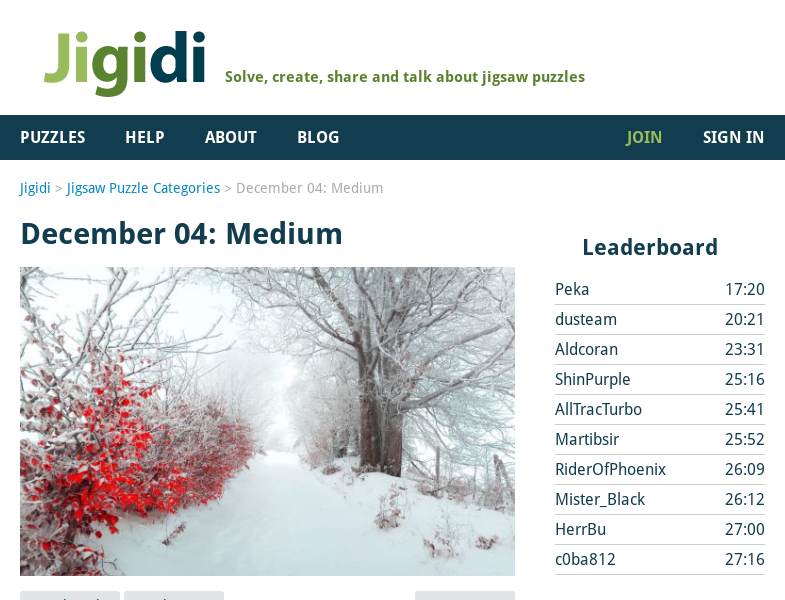

'Puzzle Image'

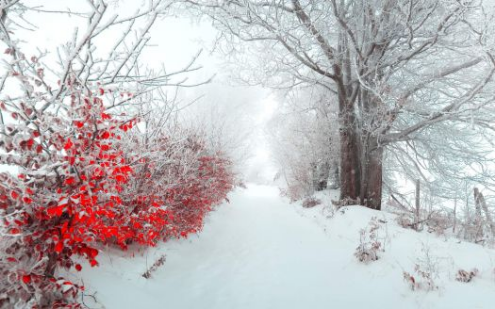

'Username'

'Score'

In [ ]:
# Display results on this console for debugging purposes
from IPython.display import Image, display
display("Full Page")
display(Image(full_page_img))

display("Puzzle Image")
display(Image(puzzle_img))

display("Username")
display(Image(username_img))

if score_img:
    display("Score")
    display(Image(score_img))

## Convert user img URL to Numpy array

In [ ]:
# https://stackoverflow.com/questions/21061814/how-can-i-read-an-image-from-an-internet-url-in-python-cv2-scikit-image-and-mah
from skimage import io as skimage_io

submitted_img = None
# Load image from URL
try:
    submitted_img = skimage_io.imread(USER_IMAGE_URL)
except:
    print("Error: image couldn't be read from URL")
    # Do other exception handling here or something

## Debugging: Verify your image was correctly downloaded

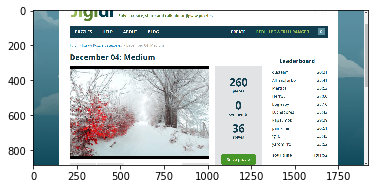

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(submitted_img, interpolation='nearest')
plt.show()

## Perform Template Matching (Scale Invariant)

In [ ]:
from PIL import Image as PIL_Image
import io
import numpy as np 
import imutils
import cv2
import pytesseract

def binary_to_np(bin_img):
    img = PIL_Image.open(io.BytesIO(bin_img))
    return np.asarray(img)

def template_match(img, target, scale):
    tmp_img = imutils.resize(img, width = int(img.shape[1] * scale))
    template_h, template_w, _ = target.shape

    h, w, _ = tmp_img.shape
    if (h < template_h or w < template_w):
        return (0, 0, 0)

    res = cv2.matchTemplate(tmp_img, target, cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    top_left = min_loc
    bottom_right = (top_left[0] + template_w, top_left[1] + template_h)
    
    # Debugging stuff: print values and boxed image 
    """
    print(scale, min_val, max_val, min_loc, max_loc, 1 - min_val)
    cv2.rectangle(tmp_img, top_left, bottom_right, 255, 4)
    from google.colab.patches import cv2_imshow
    cv2_imshow(tmp_img)
    """

    return (1 - min_val, top_left, bottom_right)

def has_match(binary_img, submitted_img, similarity_threshold=0.98):
    # Convert binary (png) to numpy array
    curr_img = binary_to_np(binary_img)

    target_img = curr_img.copy()
    search_img = submitted_img.copy()

    # Search from small img to large img
    current_scale = 0.2
    current_similarity, top_left, bottom_right = template_match(search_img, target_img, current_scale)
    if current_similarity >= similarity_threshold:
            return True
    STEP_THRESHOLD = 0.0005
    SCALE_LIMIT = 3
    scale_step = 0.1
    direction = 1 # +ve for increasing in scale, -ve for decreasing in scale
    iterations = 0
    while current_scale < SCALE_LIMIT and scale_step > STEP_THRESHOLD:
        new_scale = current_scale + scale_step * direction
        new_similarity, top_left, bottom_right = template_match(search_img, target_img, new_scale)
        # print(current_scale, current_similarity, new_scale, new_similarity, scale_step)
        iterations += 1
        if new_similarity >= similarity_threshold:
            # print(new_scale, iterations)
            return (True, (new_scale, top_left, bottom_right))
        if current_similarity > new_similarity: # Previous similarity was smaller
            # flip direction and change scale more slowly
            direction *= -1
            scale_step *= 2.0/3.0
            # print("flip")
        else: # Previous similarity was less
            current_scale = new_scale
            current_similarity = new_similarity
    # print(current_scale)
    """
    tmp_img = imutils.resize(search_img, width = int(search_img.shape[1] * current_scale))
    cv2.rectangle(tmp_img, top_left, bottom_right, 0, 4)
    from google.colab.patches import cv2_imshow
    cv2_imshow(tmp_img)
    """
    return (False, None)

# test_img = binary_to_np(score_img)

# custom_config = r'--oem 3 --psm 6'
# pytesseract.image_to_string(test_img, config=custom_config)

'Your time 1:01:52\n\x0c'

0.2 0.9411527290940285 0.30000000000000004 0.9419807717204094 0.1
0.30000000000000004 0.9419807717204094 0.4 0.9437538310885429 0.1
0.4 0.9437538310885429 0.5 0.9437592662870884 0.1
0.5 0.9437592662870884 0.6 0.9459382966160774 0.1
0.6 0.9459382966160774 0.7 0.9597941152751446 0.1
0.7 0.9597941152751446 0.7999999999999999 0.9452670402824879 0.1
flip
0.7 0.9597941152751446 0.6333333333333333 0.9531539976596832 0.06666666666666667
flip
0.7 0.9597941152751446 0.7444444444444444 0.9516559988260269 0.04444444444444444
flip
0.7 0.9597941152751446 0.6703703703703703 0.961331807076931 0.029629629629629624
0.6703703703703703 0.961331807076931 0.6407407407407406 0.9525645412504673 0.029629629629629624
flip
0.6703703703703703 0.961331807076931 0.6901234567901233 0.9585398137569427 0.019753086419753083
flip
0.6703703703703703 0.961331807076931 0.6572016460905349 0.9855762096121907 0.013168724279835387
0.6572016460905349 0.9855762096121907 0.6440329218106995 0.9512256570160389 0.013168724279835387


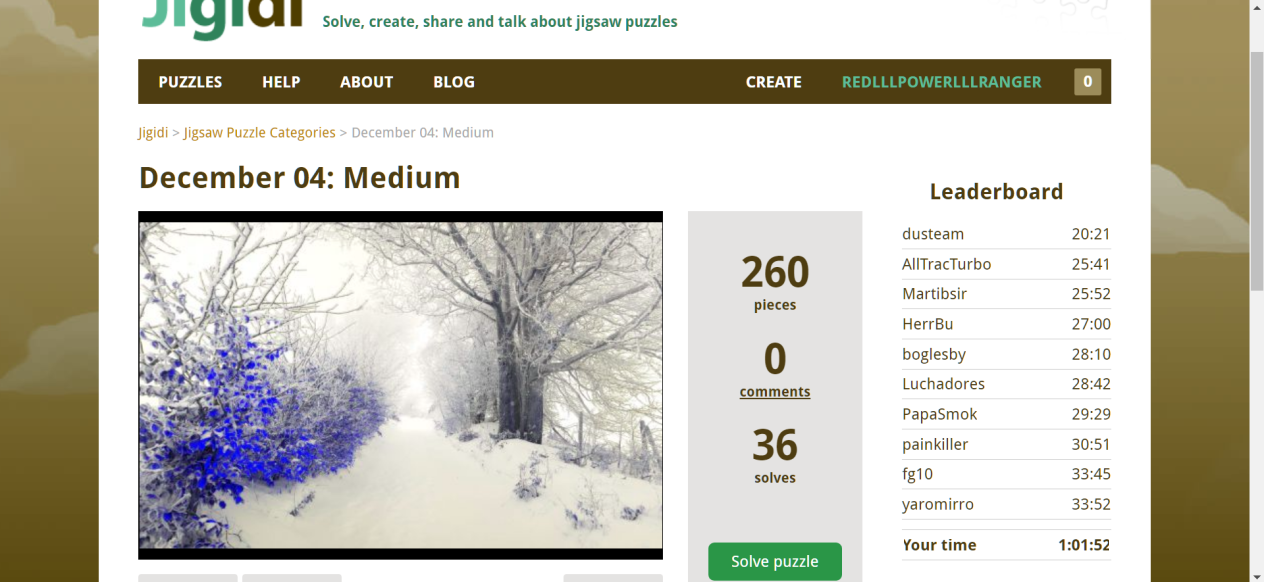

False

In [ ]:
display(Image(score_img))
has_match(score_img, submitted_img)

In [ ]:
# OCR is trivial to use since it's just a 1 liner to call the pytesseract module
# ocr_string = pytesseract.image_to_string(tmp_img, config=r'--oem 3 --psm 6')

# Putting all the Python code in 1 code block

In [ ]:
# Take note the required modules
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from PIL import Image as PIL_Image
from skimage import io as skimage_io
import io
import numpy as np 
import imutils
import cv2
import pytesseract

# from google.colab.patches import cv2_imshow

def start_chrome_driver():
    # Start the driver
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    return webdriver.Chrome('/usr/bin/chromedriver',chrome_options=chrome_options)

def binary_to_np(bin_img):
    # Convert a binary image to a numpy array
    img = PIL_Image.open(io.BytesIO(bin_img))
    return np.asarray(img)

def template_match(img, target, scale):
    tmp_img = imutils.resize(img, width = int(img.shape[1] * scale))
    template_h, template_w, _ = target.shape

    h, w, _ = tmp_img.shape
    if (h < template_h or w < template_w):
        return (0, 0, 0)

    res = cv2.matchTemplate(tmp_img, target, cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    top_left = min_loc
    bottom_right = (top_left[0] + template_w, top_left[1] + template_h)
    
    # Debugging stuff: print values and boxed image 
    """
    print(scale, min_val, max_val, min_loc, max_loc, 1 - min_val)
    cv2.rectangle(tmp_img, top_left, bottom_right, 255, 4)
    from google.colab.patches import cv2_imshow
    cv2_imshow(tmp_img)
    """

    return (1 - min_val, top_left, bottom_right)

def has_match(binary_img, submitted_img, similarity_threshold=0.98):
    # Convert binary (png) to numpy array
    curr_img = binary_to_np(binary_img)

    target_img = curr_img.copy()
    search_img = submitted_img.copy()

    # Search from small img to large img
    current_scale = 0.2
    current_similarity, top_left, bottom_right = template_match(search_img, target_img, current_scale)
    if current_similarity >= similarity_threshold:
            return True
    STEP_THRESHOLD = 0.0005
    SCALE_LIMIT = 3
    scale_step = 0.1
    direction = 1 # +ve for increasing in scale, -ve for decreasing in scale
    iterations = 0
    while current_scale < SCALE_LIMIT and scale_step > STEP_THRESHOLD:
        new_scale = current_scale + scale_step * direction
        new_similarity, top_left, bottom_right = template_match(search_img, target_img, new_scale)
        iterations += 1
        if new_similarity >= similarity_threshold:
            return (True, (new_scale, top_left, bottom_right))
        if current_similarity > new_similarity: # Previous similarity was smaller
            # flip direction and change scale more slowly
            direction *= -1
            scale_step *= 2.0/3.0
        else: # Previous similarity was less
            current_scale = new_scale
            current_similarity = new_similarity
    return (False, None)

# Example usage

# Example Data
puzzles = [{
    "puzzle_url": "https://www.jigidi.com/jigsaw-puzzle/eyjwl91s/december-04-medium/",
    "user_submissions": [
        { # Correct submission
            "username": "REDLLLPOWERLLLRANGER", 
            "h": "1", 
            "m": "01", # Note, minutes should have 0 in front. This is not verified in this code
            "s": "52", 
            "proof_url": "https://i.imgur.com/RHNQFmc.png", 
            "timestamp": None, 
            "verified": False
        },
        { # Correct submission, wrong timestamp
            "username": "REDLLLPOWERLLLRANGER", 
            "h": "0", 
            "m": "25", 
            "s": "42", 
            "proof_url": "https://i.imgur.com/RHNQFmc.png", 
            "timestamp": None, 
            "verified": False
        },
        { # Correct submission, wrong username
            "username": "REDJLLPOWERLLLRANGER", 
            "h": "1", 
            "m": "01", 
            "s": "52", 
            "proof_url": "https://i.imgur.com/RHNQFmc.png", 
            "timestamp": None, 
            "verified": False
        },
        { # Wrong puzzle submitted
            "username": "REDLLLPOWERLLLRANGER", 
            "h": "0", 
            "m": "8", 
            "s": "35", 
            "proof_url": "https://i.imgur.com/uYeAOEe.png", 
            "timestamp": None, 
            "verified": False
        },
    ],
}]

# 1. Pre-processing the example data
for puzzle in puzzles:
    for submission in puzzle["user_submissions"]:
        if int(submission['h']) == 0:
            submission['timestamp'] = "{0}:{1}".format(submission['m'], submission['s'])
        else:
            submission['timestamp'] = "{0}:{1}:{2}".format(submission['h'], submission['m'], submission['s'])

# 2. Start the Chrome driver
driver = start_chrome_driver()

for puzzle in puzzles:
    # Go to Jigidi page for the puzzle
    driver.get(puzzle["puzzle_url"])
    # Get puzzle image we'll use later on
    puzzle_img = driver.find_element_by_xpath("//img[@itemprop='image']").screenshot_as_png 
    # Get elements we will use later on
    join_element_text = driver.find_element_by_xpath("//li[@class='rli highlight']").find_element_by_tag_name('a').find_element_by_tag_name('span')
    leaderboard_list = driver.find_elements_by_xpath("//div[@class='leaderboard']")[1].find_element_by_tag_name('ol')
    # Note: if player was originally on the leaderboards but booted off by the time verification occurs, this verification would likely fail
    leaderboard_text = driver.find_element_by_xpath("//div[@class='leaderboard']").get_attribute('innerText')

    # Loop through every submission
    for submission in puzzle["user_submissions"]:
        PUZZLE_VERIFIED = False
        USERNAME_VERIFIED = False
        SCORE_VERIFIED = False

        # Get template images for the username and score
        driver.execute_script("arguments[0].innerText = arguments[1]", join_element_text, submission['username'])
        username_img = join_element_text.screenshot_as_png 

        score_img = None
        expected_leaderboard_text = submission['username'] + submission['timestamp']
        if expected_leaderboard_text.lower() in leaderboard_text.lower():
            SCORE_VERIFIED = True
        else: # not in leaderboards
            driver.execute_script("arguments[0].innerHTML = arguments[1]", leaderboard_list, '<li class="me" style="border-bottom: 0; padding: 0; margin: 0;"><span>Your time</span><span class="time">{0}</span></li>'.format(submission['timestamp']))
            score_img = leaderboard_list.screenshot_as_png

        # Grab user's submitted screenshot
        submitted_img = None
        try:
            submitted_img = skimage_io.imread(submission['proof_url'])
        except:
            print("Error: image couldn't be read from URL")
            # TODO: Do other exception handling here or something
            
        if submitted_img == None:
            print("Automatic verification failed (Cannot download proof image)")
            # TODO: Do other exception handling here or something
            continue

        # Optimization: scale submitted_img outside of the function so we don't have to do it 3 times
        # Here I assume the search_scale is unchanged at .2
        search_img = imutils.resize(submitted_img, width = int(submitted_img.shape[1]))

        # Perform visual verification of puzzle, username and score.
        # Note that you can actually perform early termination if any of them fail.
        # I omitted this optimization for code simplicity / if you want to highlight the errors in the submission.
        PUZZLE_VERIFIED, _ = has_match(puzzle_img, search_img)
        
        USERNAME_VERIFIED, boundingbox_details = has_match(username_img, search_img)
        if USERNAME_VERIFIED:
            scale, top_left, bottom_right = boundingbox_details
            # Double-check with OCR
            # Scale search_img to scale we found the item
            tmp_img = imutils.resize(search_img, width = int(search_img.shape[1] * scale))
            # Crop search_img
            tmp_img = tmp_img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
            # Perform OCR on cropped region
            ocr_string = pytesseract.image_to_string(tmp_img, config=r'--oem 3 --psm 6').strip()

            print("Database:", submission["username"], "OCR: ", ocr_string)
            USERNAME_VERIFIED = USERNAME_VERIFIED and ocr_string == submission["username"]

        if not SCORE_VERIFIED:
            SCORE_VERIFIED, boundingbox_details = has_match(score_img, search_img)
            if SCORE_VERIFIED:
                scale, top_left, bottom_right = boundingbox_details
                # Double-check with OCR
                # Scale search_img to scale we found the item
                tmp_img = imutils.resize(search_img, width = int(search_img.shape[1] * scale))
                # Crop search_img
                tmp_img = tmp_img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
                # Perform OCR on cropped region
                ocr_string = pytesseract.image_to_string(tmp_img, config=r'--oem 3 --psm 6')
                # Clean up the string to remove trash
                cleaned_string = "".join(ocr_string.lower().replace('your time','').split())

                print("Database:", submission["timestamp"], "OCR:", ocr_string)
                SCORE_VERIFIED = SCORE_VERIFIED and cleaned_string == submission["timestamp"]

        # Compile the verification status and run other code
        submission['verified'] = PUZZLE_VERIFIED and USERNAME_VERIFIED and SCORE_VERIFIED

        if submission['verified']:
            # TODO: do things with this information
            print(submission)
            print("Verified")
        else:
            # TODO: tag submission for manual verification
            print(submission)
            print("Automatic verification failed")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: use options instead of chrome_options


0.6333333333333333 7
0.6703703703703703 9
Database: REDLLLPOWERLLLRANGER OCR:  REDLLLPOWERLLLRANGER
0.6572016460905349 12
Database: 1:01:52 OCR: Your time 1:01:52

User checked out
0.6333333333333333 7
0.6703703703703703 9
Database: REDLLLPOWERLLLRANGER OCR:  REDLLLPOWERLLLRANGER
Automatic verification failed
0.6333333333333333 7
0.6572016460905349 12
Database: 1:01:52 OCR: Your time 1:01:52

Automatic verification failed
0.6703703703703703 9
Database: REDLLLPOWERLLLRANGER OCR:  REDLLLPOWERLLLRANGER
Automatic verification failed
